<a href="https://colab.research.google.com/github/piziomo/Generative-AI-Trainings/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: what is an autoencoder?

An **autoencoder** is a neural network model trained to encode and decode an input in such a way that the reconstructed output, in this lab it will be an image, resembles the original as much as possible. An autoencoder is made up of two parts: an encoder and a decoder.

You can think of an autoencoder as using one subnetwork (the encoder) to project an input image down into a lower dimensionality — in an extreme case, 2 dimensions, as visualized below — before using another subnetwork (the decoder) to reproject it back into the dimensionality of the original input, as illustrated in Figure 3-2.

Note: the material was adapted from Foster (2024).

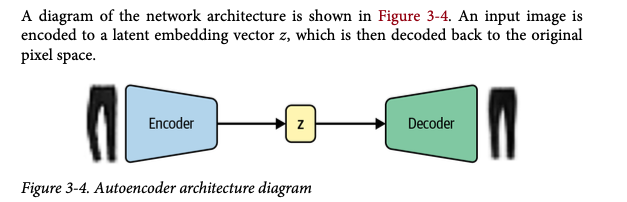

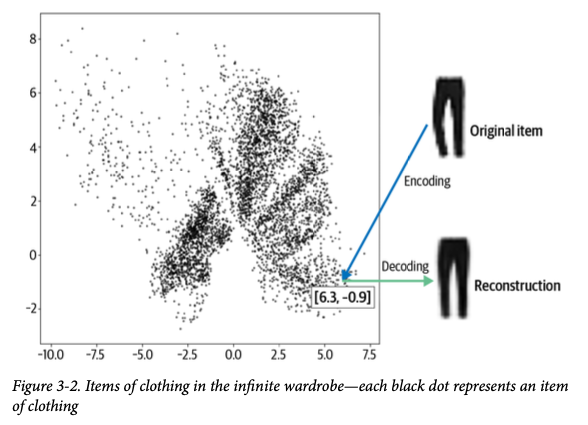

The **encoder** network takes high-dimensional data and compresses it into a lower-dimensional vector.
- For example, an encoder could take in a 28x28 image and compress it to two values that then can be positioned on a 2D plane. Basically, our image becomes a point :)



The **decoder** network, on the other hand, takes the compressed input and tries to turn it back to the original input.
- For example, it could take the point coordinates on a 2D space and tries to reconstruct an original image (28x28) based on these two values (X, Y).

Why is it a generative model?
- Because we can ask it to decode *any* point in the 2D space, including those points that do not have any associated items. In this way, it can generate new examples!

# Importing and preparing data

This week we will *not* be working with the MNIST dataset for image generation. Instead, we will be generating fashion items 👚

The fashion-MNIST dataset, created and released by Zalando, is similar to MNIST:
- the samples are grayscale 28x28 images;
- our training dataset consists of 60,000 examples;
- out testing dataset consists of 10,000 examples;
- there are 10 item classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

You can learn more about the dataset here: https://www.tensorflow.org/datasets/catalog/fashion_mnist

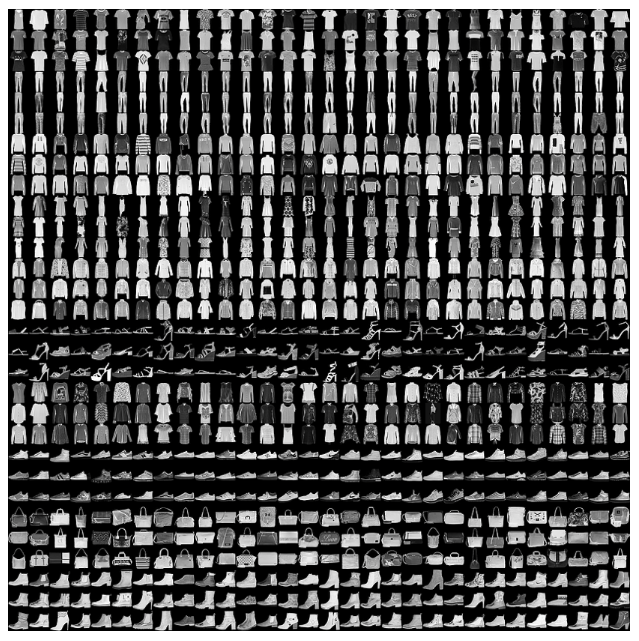

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import layers
from keras import backend
from keras import models
from keras import utils
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# Import fashion-mnist dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
'''
As always, we will scale image pixels to be in range from 0 to 1.
We will also increase the size of the images to 32x32 by adding 0s (black space).
This will help to ensure that downscaling in the encoder and upscaling in
the decoder is consistent. This is architecture-specific, so don't worry too
much about this unless you'll be building your own model :)
'''

# training data
train_images_resh = train_images.astype("float32")/255.0
train_images_resh = np.pad(train_images_resh, ((0,0), (2,2), (2,2)), constant_values = 0.0)
train_images_resh = np.expand_dims(train_images_resh, -1)

# testing data
test_images_resh = test_images.astype("float32")/255.0
test_images_resh = np.pad(test_images_resh, ((0,0), (2,2), (2,2)), constant_values = 0.0)
test_images_resh = np.expand_dims(test_images_resh, -1)

# create an item dictionary; this will make it easier for us to find out to
# which category each numeric label refers to.
items_dict = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}


In [ ]:
train_image = 0
np.set_printoptions(linewidth=200, edgeitems=10, formatter={'int':lambda x: f'{x:4}'}, precision=2)
print(f"Shape of a train image: {train_images[train_image].shape}")
print(f"Train image: {train_images[train_image]}")

Shape of a train image: (28, 28)
Train image: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    1    0    0   13   73    0    0    1    4    0    0    0    0    1    1    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    3    0   36  136  127   62   54    0    0    0    1    3    4    0    0    3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    6    0  102  204  176  134  144  123   23    0    0    0    0   12   10    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0  155  236  207  178  107

In [ ]:
np.set_printoptions(threshold=np.prod(train_images_resh[train_image].squeeze().shape), precision=2, suppress=True)
print(f"Shape of a reshaped train image: {train_images_resh[train_image].shape}")
print(f"Reshaped train image: {train_images_resh[train_image]}")

Shape of a reshaped train image: (32, 32, 1)
Reshaped train image: [[[0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]
  [0.  ]


Item class: Ankle boot


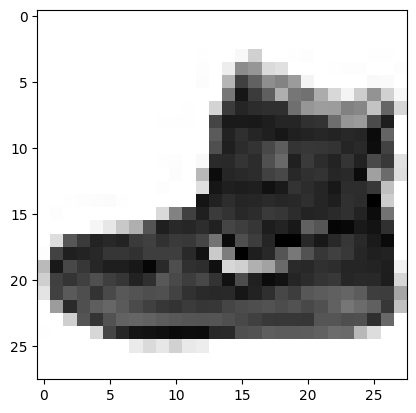

In [ ]:
train_image_label = train_labels[train_image]
print(f"Item class: {items_dict[train_image_label]}")
plt.imshow(train_images[train_image], cmap = "Greys")

### Encoder architecture

Our encoder will be a convolutional neural network that will have the following layers: an input layer, 3 convolutional layers, and one dense layer for an ouput.



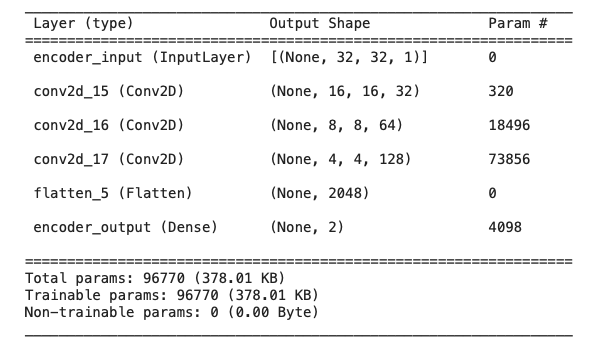

Why does the output layer have 2 output units instead of 10, the number of categories present in the fashion-MNIST dataset?

- The output layer will have 2 units because we are interested not in image classification but in image generation. For this we will need point coordinates that consist of two values - X and Y - because we are working on a 2D space. As a result, the aim of the encoder is to reduce the input image to these 2 values, so it can be positioned in a 2D space in a way that the items belonging to the same class are clustered as closely together as possible. Put simply, one unit in the output layer will encode an X value and another unit will encode a Y value.

In [ ]:
# Encoder architecture

encoder_input = layers.Input(
    shape = (32,32,1),
    name = "encoder_input"
)
x = layers.Conv2D(filters = 32,
                  kernel_size = (3,3),
                  strides = 2,
                  activation = "relu",
                  padding = "same"
                  )(encoder_input)
x = layers.Conv2D(filters = 64,
                  kernel_size = (3,3),
                  strides = 2,
                  activation = "relu",
                  padding = "same"
                  )(x)

x = layers.Conv2D(filters = 128,
                  kernel_size = (3,3),
                  strides = 2,
                  activation = "relu",
                  padding = "same")(x)

shape_before_flattening = keras.backend.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(2,
                              name = "encoder_output")(x)

encoder = models.Model(inputs = encoder_input,
                       outputs = encoder_output)

encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder architecture

The architecture of a decoder will mirror the encoder. We will start with an input layer that will take two values (point coordinates!), then this will be turned into a longer vector and, finally, 3 convolutional layers will be stacked resulting in a 28x28 grayscale image output.

Note: instead of using convolutional layers as in the encoder, we will stack the convolutional transpose layers. They use the same principles as the standard convolutional layers, but, instead of shrinking the input, they increase the size of an input.

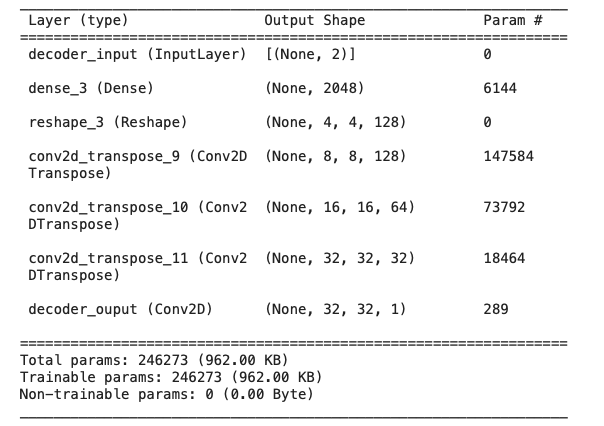

In [ ]:
# Decoder architecture

decoder_input = layers.Input(shape = (2,), name = "decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
print(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    filters = 128,
    kernel_size = (3,3),
    strides = 2,
    activation = "relu",
    padding = "same"
)(x)
x = layers.Conv2DTranspose(
    filters = 64,
    kernel_size = (3,3),
    strides = 2,
    activation = "relu",
    padding = "same"
)(x)
x = layers.Conv2DTranspose(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    activation = "relu",
    padding = "same"
)(x)
decoder_output = layers.Conv2D(
    filters = 1,
    kernel_size = (3,3),
    strides = 1,
    activation = "sigmoid",
    padding = "same",
    name = "decoder_ouput"
)(x)

decoder = models.Model(inputs = decoder_input,
                       outputs = decoder_output)

decoder.summary()

<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_5>


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_ouput (Conv2D)               │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Build an autoencoder

In [ ]:
## Join the encoder and decoder to build an autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))

### Compile and train the model

In [ ]:
# Compilation

autoencoder.compile(optimizer = "adam",
                    loss = "binary_crossentropy") # binary because our output layer has only to units

In [ ]:
# Training

autoencoder.fit(
    train_images_resh,
    train_images_resh,
    epochs = 15,
    batch_size = 100
)

Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3618
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2588
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2541
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2528
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2504
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2491
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2491
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2483
Epoch 9/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2472
Epoch 10/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2471
Epoch 11/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2464
Epoch 12/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2465
Epoch 13/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2459
Epoch 14/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2452
Epoch 15/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

### Reconstructing the images

In [ ]:
# we could task the model with reconstructing the first 1,000 images
# example_images = test_images_resh[:1000]
predictions = autoencoder.predict(test_images_resh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


### Visualising predictions

Label of an original item: Dress


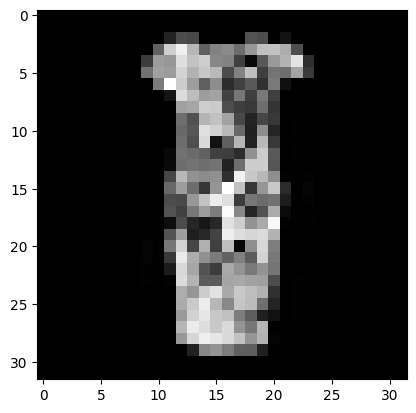

In [ ]:
# find out the original label of a reconstructed image
prediction = 100
label = test_labels[prediction]

# visualise the original image
print(f"Label of an original item: {items_dict[label]}")
plt.imshow(test_images_resh[prediction],cmap = "gray")

Reconstructed image


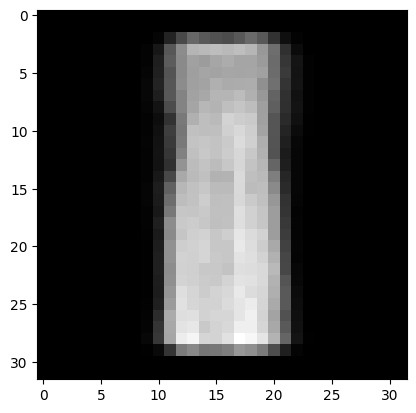

In [ ]:
# Which predicted image do you want to visualise?

# Visualise a reconstructed image
print(f"Reconstructed image")
plt.imshow(predictions[prediction], cmap = "gray")

In [ ]:
# an image embedding refers to the image's location on the 2D space
# an embedding consists of an X and Y values
embeddings = encoder.predict(test_images_resh)
print(embeddings[1:4,])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[ 4.87 -1.18]
 [ 2.62  7.93]
 [ 1.17  4.73]]


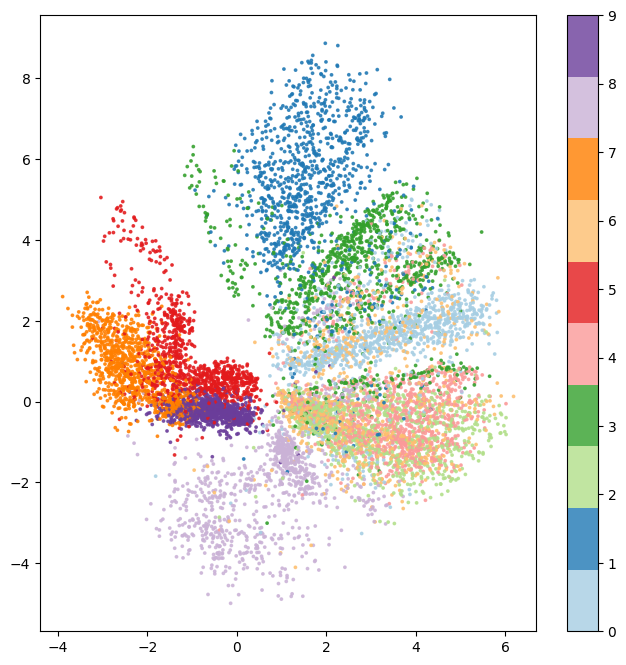

In [ ]:
# We can visualise the test data embeddings

'''
ID Clothing label
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
'''

# creating a colourblind-friendly colour palette
cb_cmap = plt.cm.colors.ListedColormap(["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99",
                       "#E31A1C", "#FDBF6F","#FF7F00", "#CAB2D6", "#6A3D9A"])
print(cb_cmap)


plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap=cb_cmap,
    c= test_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

### New image generation

#### Randomly generated image embeddings


Now it's time to generate the images that are not in our testing dataset.
Specifically, we will generate 6 new images. To do this we will:
- generate 6 pairs of random X,Y values
- we will constrain our random value generator by defining the boundaries from which the values can be selected. This will be informed by the embeddings of our test data -- its minimum and maximum values.

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
print(f"mins: {mins}, maxs:{maxs}")

# Sample some points in the latent space
grid_width, grid_height = (3, 2)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)
# Decode the sampled points
reconstructions = decoder.predict(sample)

mins: [-3.89 -4.99], maxs:[6.19 8.87]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


<Figure size 800x800 with 0 Axes>

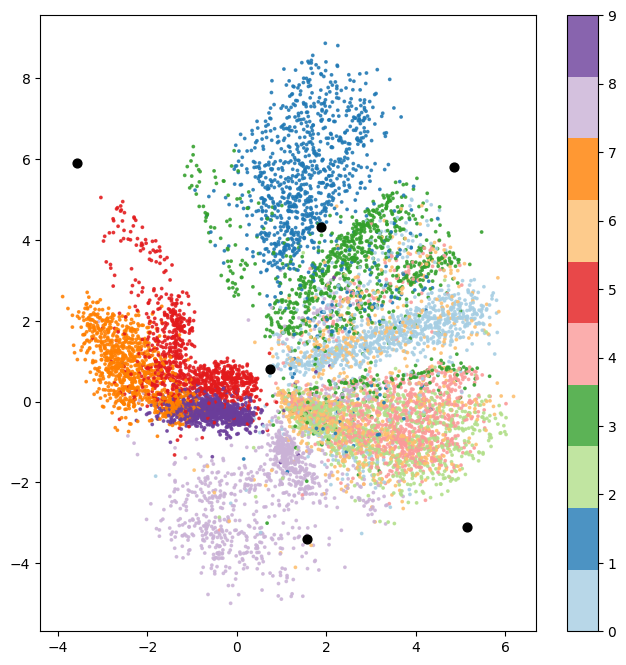

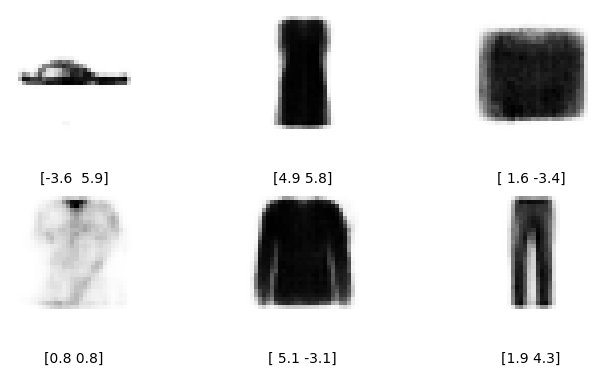

In [ ]:
# Visualise the new images and their location on a 2D space

figsize = 8
plt.figure(figsize=(figsize, figsize))

# the original embeddings
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap=cb_cmap,
    c= test_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()

# and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="black", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


#### Manually defining image embeddings


In [ ]:
# Define the grid size; Its size should reflect the number of images
# you plan on generating as otherwise you will get a warning
grid_width, grid_height = (2, 1)

### write the embeddings here
# embeddings of image 1 (an example)
X1 = 2.54
Y1 = -0.43

# Now it's your turn to add embeddings! Do so by following an example (embedding 1)
# embeddings of image 2
# X2 =
# Y2 =

# embeddings of image 3
# X3 =
# Y3 =


# ... add more embeddings if you want, but don't forget to change the
# 'sample' (below) accordingly

# if you added the embeddings for images 2 and 3 then don't forget to uncomment
# the lines below by deleting the #
sample = [[X1, Y1],
          # [X2, Y2],
          # [X3, Y3]
          ]
sample = np.asarray(sample)
#sample = np.expand_dims(sample, 1)

print(sample)
#print(sample.ndim)
print(len(sample))

# Decode the sampled points
reconstructions = decoder.predict(sample)

[[ 2.54 -0.43]]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


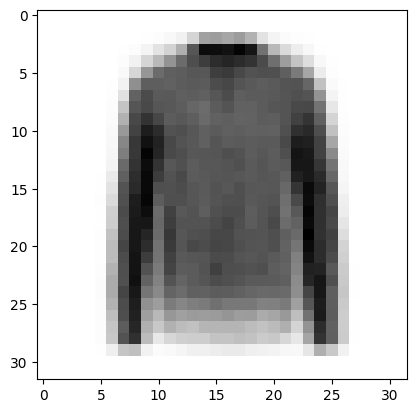

In [ ]:
plt.imshow(reconstructions[0, :, :], cmap = "Greys")

<Figure size 800x800 with 0 Axes>

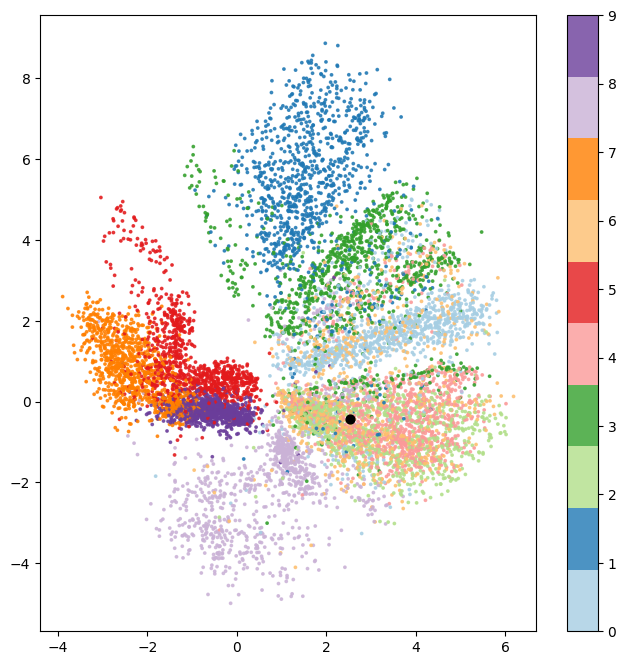

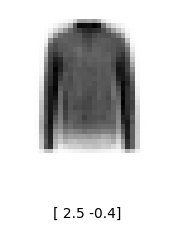

In [ ]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap=cb_cmap,
    c= test_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()

plt.scatter(sample[:, 0], sample[:, 1], c="black", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(sample)):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")